In [15]:
import pandas as pd
from itertools import combinations
from collections import defaultdict, Counter
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

# Preprocessing Colexification Patterns into Lang2lang graph with overlapping Colexification Patterns

In [3]:
def co_occurrence_table(df: pd.DataFrame, by_id: str):
    # df["Colex_ID"] = df["Colex_ID"].astype("Int64")
    df["Colex_ID"] = df["Colex_ID"].astype("Int64")
    print('len of colexification df:', len(df))
    # df = df.drop_duplicates(subset=[by_id, "Colex_ID"])
    df = df.drop_duplicates(subset=[by_id, "Colex_ID"])
    print(f'len of df after droping duplicates for {by_id}:', len(df))
    codf = df[[by_id, "Colex_ID"]]
    co_dict = defaultdict(int)

    num_of_colexification_ignoring_forms = 0
    for k, group in codf.groupby(["Colex_ID"]):
        num_of_colexification_ignoring_forms += len(group)
        combs = combinations(group[by_id].tolist(), 2)
        for p in combs:
            t1, t2 = sorted(p) # sorted 
            if t1 != t2:
                co_dict[p] += 1
    return co_dict, num_of_colexification_ignoring_forms

In [4]:
colex_df= pd.read_csv("../datasets/colexifications/colex_clics3.csv")

In [5]:
colex_df.head(2)

,Form_ID_x,Form_ID_y,Concepticon_ID_x,Concepticon_ID_y,Colex_ID,Language_ID,Parameter_ID,Value,Form,Language_Name,...,ISO639P3code,Macroarea,Family,Wals_ID,Wals_Name,Latitude,Longitude,Glottocode_wals,Subfamily,Genus
0,Chaozhou-61_soilearth-1,Chaozhou-60_mudearth-1,1228,640,0,Chaozhou,61_soilearth,tʰou⁵⁵,tʰou⁵⁵,Chaozhou,...,NaN,Eurasia,Sino-Tibetan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Chengdu-61_soilearth-1,Chengdu-60_mudearth-1,1228,640,0,Chengdu,61_soilearth,ȵi³¹pa⁴⁴,ȵi³¹pa⁴⁴,Chengdu,...,NaN,NaN,Sino-Tibetan,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
colex_dict, num_of_colexification_ignoring_forms =  co_occurrence_table(colex_df, "Glottocode_clics")

len of colexification df: 76346
len of df after droping duplicates for Glottocode_clics: 66827


In [7]:
glotto2colex_nr = colex_df.groupby(["Glottocode_clics"])["Colex_ID"].count().to_dict()

In [8]:
colexnr_array = list(glotto2colex_nr.values())

## Finding the threshold for including languages which contain colexifications

In [9]:
np.max(colexnr_array)

np.int64(1335)

In [18]:
def get_quantile_box(arr):
    # quantiles=np.quantile(arr, np.linspace(0,1,1335))
    # plt.plot(np.linspace(0,1,1335), quantiles)
    plt.boxplot(arr)
    plt.xlabel('Quantile')
    plt.ylabel('Value')
    plt.title('Quantile Plot')
    plt.show()

In [23]:
q25 = np.quantile(colexnr_array, 0.25)

print(f"The 25% quantile is: {q25:.4f}")

The 25% quantile is: 3.0000


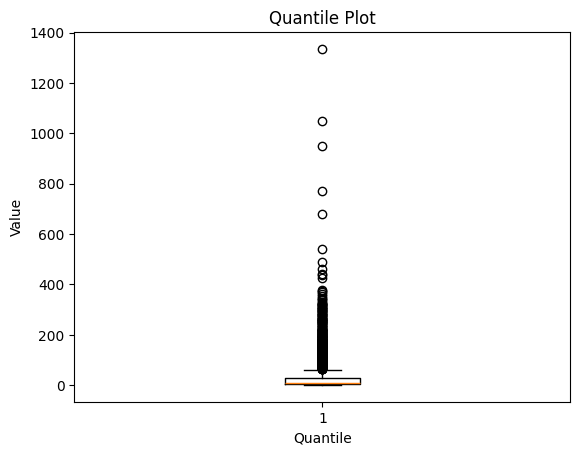

In [19]:
get_quantile_box(colexnr_array)

In [20]:
def get_quantile_violin(arr):
    # quantiles=np.quantile(arr, np.linspace(0,1,1335))
    # plt.plot(np.linspace(0,1,1335), quantiles)
    plt.violinplot(arr)
    plt.xlabel('Quantile')
    plt.ylabel('Value')
    plt.title('Quantile Plot')
    plt.show()

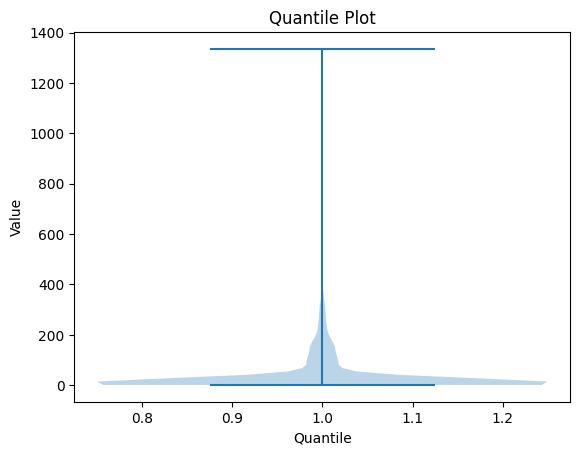

In [22]:
get_quantile_violin(colexnr_array)

# Get the Colexification Language to Language Graph

In [24]:
lang2colex_nr = {lang: colex_nr for lang,colex_nr in glotto2colex_nr.items() if colex_nr>=3}

In [27]:
len(lang2colex_nr), len(glotto2colex_nr)

(1641, 1989)

In [31]:
langs_list = list(lang2colex_nr.keys())

In [38]:
df = pd.DataFrame(list(colex_dict.items()), columns=["Key", "Value"])

In [40]:
df[["Target", "Source"]] = pd.DataFrame(df["Key"].tolist(), index=df.index)

In [44]:
df = df.rename(columns={"Value":"Weight"})

In [45]:
df = df[["Target", "Source", "Weight"]]

In [49]:
df["Colex_target"] = df["Target"].apply(lambda x: lang2colex_nr.get(x, None))
df["Colex_source"] = df["Source"].apply(lambda x: lang2colex_nr.get(x, None))

In [51]:
df = df.dropna()

In [58]:
df.head(2) 

,Target,Source,Weight,Colex_target,Colex_source
0,chao1238,chen1267,3,8.0,9.0
1,chao1238,fuzh1239,4,8.0,7.0


In [54]:
from nltk.metrics import *
import pandas as pd

bm = BigramAssocMeasures

In [55]:
total_colex_nr = sum(list(lang2colex_nr.values()))
total_colex_nr

75842

In [59]:
def calculate_pmi(x,y,z):
    pmi = bm.pmi(x,(y,z), total_colex_nr)
    return pmi

In [60]:
df["pmi"] = df.apply(lambda row: calculate_pmi(row["Weight"], row["Colex_target"], row["Colex_source"]), axis=1)

/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_94032/4107798813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pmi"] = df.apply(lambda row: calculate_pmi(row["Weight"], row["Colex_target"], row["Colex_source"]), axis=1)


In [63]:
df.to_csv("../datasets/lang2lang/clics3.csv", index=False)

In [64]:
def get_boxplot(arr):
    # quantiles=np.quantile(arr, np.linspace(0,1,1335))
    # plt.plot(np.linspace(0,1,1335), quantiles)
    plt.boxplot(arr)
    plt.xlabel('PMI')
    plt.ylabel('Value')
    plt.title('Plot')
    plt.show()

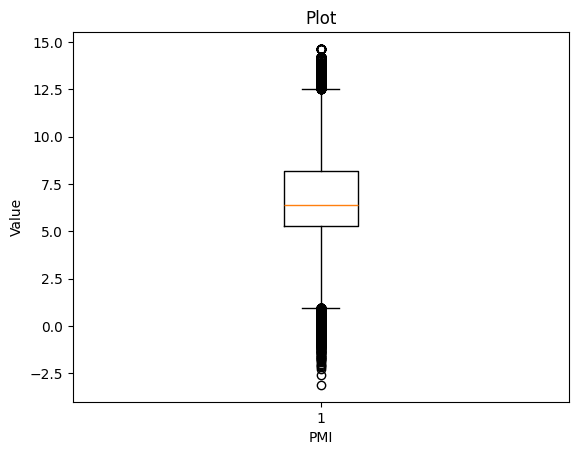

In [65]:
get_boxplot(df["pmi"].tolist())